# 실습 1. basic model and XOR

이 실습에서는 Keras를 이용하여 실제 신경망 모델을 설계하고 학습하는 방법을 배웁니다.

그리고 XOR 연산을 신경망이 어떻게 학습하는지 볼 것입니다.

### 화면을 전체 폭의 90%로, 최대한 넓게 사용하도록 합니다. 최대 100%까지 설정할 수 있습니다.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important;}</style>"))

## 0. 필요한 모듈들을 불러옵니다.
* keras는 Keras 라이브러리로, 바탕에 tensorflow를 사용합니다.
* numpy는 Python용 수학 라이브러리로 행렬 연산 등에 사용하기 편리합니다.
* matplotlib.pyplot는 가장 널리 사용되는 plotting 라이브러리 중 하나입니다.

In [2]:
import keras
import keras.backend as K
import keras.layers as Layers
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


## A. 무작위 데이터 + FNN w. 1 hidden layer

## 1. 데이터를 준비합니다.

학습을 위해 필요한 데이터를 준비하는 것은 어쩌면 신경망 활용에 있어서 가장 중요한 일입니다.

우선은 무작위 데이터를 준비해 봅시다. 신경망의 입력은 $[-10, 10]$ 구간의 실수 두 개, 출력은 $[-1, 1]$ 구간의 실수 한 개로 가정하고 총 100 쌍을 준비하면 데이터의 모양은 다음처럼 됩니다.

* 입력자료 : #columns = 2, #rows = 100
* 출력자료 : #columns = 1, #rows = 100

무작위 데이터를 만들기 위해 **np.random.rand(num_data)** 함수를 사용합니다. 이것은 $[0, 1]$ 사이 임의의 난수를 num_data 개 생성합니다.

In [3]:
num_data = 100

x = np.random.rand(2 * num_data).reshape((100, 2)) * 20 - 10
y = np.random.rand(num_data) * 2 - 1
print('x = ', x[:10])
print('y = ', y[:10])

x =  [[-3.27345956  8.04832081]
 [-7.87164427  1.77741267]
 [-2.72885164 -0.34644372]
 [-7.01558749 -4.33375891]
 [-6.9816352  -7.72088717]
 [ 5.48964558 -0.47990116]
 [-7.22610994 -3.21166756]
 [-7.18362802 -0.09033859]
 [-0.94462262 -9.42464437]
 [ 4.4202558  -4.43951662]]
y =  [ 0.91647159 -0.30855729 -0.95915489  0.74438586 -0.70461184 -0.60576762
 -0.2969342   0.16363772 -0.94146045  0.56703427]


## 2. 모델을 만듭니다.

모델을 생성하기 위한 코드입니다. 여기서는 dense layer를 두 개 쌓은 단순한 모델을 사용합니다. 따라서 hidden layer는 1개입니다.

* Dense layer는 신경망 구조 그림에서 많이 보던 것으로, 아래 층과 촘촘하게 이어져 있는 layer를 말합니다. Fully-connected layer(F.C. layer)라고 부르기도 합니다.

모델의 입력은 $x$이므로 입력의 shape는 $(2,)$입니다. (입력의 shape를 지정할 때 데이터의 총 개수는 고려하지 않습니다.)

입력 layer의 이름은 지정하지 않아도 되지만 여기서는 'input_layer'로 주었습니다.

In [4]:
input_layer = Layers.Input(shape = (2, ), name = 'input_layer')

첫 번째 hidden layer는 input_layer를 입력으로 삼으며 cell 2개로 이루어집니다. 이름은 'hidden_layer'로 했습니다.

activation은 활성화 함수를 가리킵니다.

In [5]:
hidden_layer = Layers.Dense(units= 2, activation='tanh', name = 'hidden_layer')(input_layer)

Instructions for updating:
Colocations handled automatically by placer.


출력 layer는 $y$에 대응해야 하므로 cell 1개로 이루어집니다. 이름은 'output_layer'입니다.

In [6]:
output_layer = Layers.Dense(units = 1, name = 'output_layer')(hidden_layer)

입력에서 출력까지 순서대로 잘 이어져 있는 모습을 머리 속에서 그릴 수 있을 것입니다.
$$ {\rm{input\_layer}} \rightarrow {\rm hidden\_layer} \rightarrow {\rm output\_layer} $$
이제 입력과 출력을 이어 모델을 만듭니다.

In [7]:
model = keras.Model(input_layer, output_layer)

# summary로 모델의 전체 모습을 간단하게 볼 수 있습니다.
model.summary(100)

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_layer (InputLayer)                     (None, 2)                               0              
____________________________________________________________________________________________________
hidden_layer (Dense)                         (None, 2)                               6              
____________________________________________________________________________________________________
output_layer (Dense)                         (None, 1)                               3              
Total params: 9
Trainable params: 9
Non-trainable params: 0
____________________________________________________________________________________________________


## 3. 이제 학습을 진행할 차례입니다.

실제 학습을 위해서는 모델을 만든 것으로 끝나지 않습니다. 이 모델이 어떤 loss를 사용하는지, 그리고 어떤 optimizer를 이용해서 학습할 것인지 지정해야 합니다.

* 우리 경우에는 실제 결과 $y$ 및 모델의 출력 $\hat{y}$가 모두 하나의 실수이므로, loss로 mean squared error를 사용합니다.

$$ MSE\left(y, \hat{y} \right) = \left|\ y - \hat{y} \ \right| ^ 2 $$

* optimizer는 Gradient Descent를 적용하는 방법(특히 learning rate $\alpha$)과 관련된 것입니다. 여기서는 rmsprop를 사용합니다.
    * optimizer에 따라 학습의 양상(학습의 효율성 등)이 바뀔 수 있습니다.

In [8]:
model.compile(optimizer = 'rmsprop', loss = 'mse')

실제 학습을 해 봅시다. 학습을 위해서는 fit 함수를 사용합니다.

In [9]:
model.fit(x = x, y = y, epochs= 10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100/100 [==============================] - 0s 4ms/step - loss: 0.4762
Epoch 2/10
100/100 [==============================] - 0s 49us/step - loss: 0.4649
Epoch 3/10
100/100 [==============================] - 0s 44us/step - loss: 0.4596
Epoch 4/10
100/100 [==============================] - 0s 48us/step - loss: 0.4537
Epoch 5/10
100/100 [==============================] - 0s 51us/step - loss: 0.4482
Epoch 6/10
100/100 [==============================] - 0s 52us/step - loss: 0.4438
Epoch 7/10
100/100 [==============================] - 0s 49us/step - loss: 0.4387
Epoch 8/10
100/100 [==============================] - 0s 51us/step - loss: 0.4351
Epoch 9/10
100/100 [==============================] - 0s 42us/step - loss: 0.4305
Epoch 10/10
100/100 [==============================] - 0s 47us/step - loss: 0.4258


학습된 결과 모델은 **model.save** 또는 **model.save_weights** 함수를 이용해서 저장할 수 있고, **model.load_weights** 함수를 이용해서 불러올 수 있습니다. 자세한 것은 **help(keras.Model.save)**, **help(keras.Model.load_weights)** 등을 참고하시기 바랍니다.

In [10]:
model.save('test_model.hdf5')
model.load_weights('test_model.hdf5')

모델을 통과한 결과인 $\hat{y}$의 값을 보려면 **predict** 함수를 사용합니다. 결과가 그다지 좋지는 않습니다.

In [11]:
y_hat = model.predict(x)
print(y_hat[:10])

[[-0.14649749]
 [ 0.23881182]
 [ 0.23605771]
 [ 0.23881495]
 [ 0.23879915]
 [-0.23257905]
 [ 0.23881572]
 [ 0.23881447]
 [ 0.16130489]
 [-0.19999963]]


## B. XOR 데이터 + FNN w. 1 hidden layer

## 1. 데이터를 준비합니다.

이번에는 XOR 연산을 학습하도록 만들어 봅니다.

신경망의 입력은 거짓/참에 대응하는 0 또는 1 값 두 개, 출력은 입력값 두 개의 XOR이므로 0 또는 1 값 1개입니다. 총 100 쌍을 준비하면 데이터의 모양은 다음처럼 됩니다.

* 입력자료 : #columns = 2, #rows = 100
* 출력자료 : #columns = 1, #rows = 100

In [12]:
num_data = 100

x_orig = np.random.rand(2 * num_data).reshape((num_data, -1))
x_logic = x_orig > 0.5
x = np.asarray(x_logic, dtype=int)
y_logic = x_logic[:, 0] ^ x_logic[:, 1]
y = np.asarray(y_logic, dtype=int)
print('x_logic = ', x_logic[:10])
print('x = ', x[:10])
print('y = ', y[:10])

x_logic =  [[ True False]
 [False  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [False  True]
 [ True False]
 [False  True]
 [ True False]
 [False  True]]
x =  [[1 0]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]]
y =  [1 1 0 0 0 1 1 1 1 1]


## 2. 모델을 만듭니다.

모델을 생성하기 위한 코드입니다. 여기서는 dense layer를 두 개 쌓은 단순한 모델을 사용합니다. 따라서 hidden layer는 1개입니다.

* Dense layer는 신경망 구조 그림에서 많이 보던 것으로, 아래 층과 촘촘하게 이어져 있는 layer를 말합니다. Fully-connected layer(F.C. layer)라고 부르기도 합니다.

만드는 과정은 **A**와 완전히 동일하므로 설명은 생략합니다.

In [13]:
input_layer = Layers.Input(shape = (2, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 2, activation='tanh', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 1, activation='tanh', name = 'output_layer')(hidden_layer)

xor_model = keras.Model(input_layer, output_layer)

# summary로 모델의 전체 모습을 간단하게 볼 수 있습니다.
xor_model.summary(100)

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_layer (InputLayer)                     (None, 2)                               0              
____________________________________________________________________________________________________
hidden_layer (Dense)                         (None, 2)                               6              
____________________________________________________________________________________________________
output_layer (Dense)                         (None, 1)                               3              
Total params: 9
Trainable params: 9
Non-trainable params: 0
____________________________________________________________________________________________________


## 3. 이제 학습을 진행할 차례입니다.

실제 학습을 위해서는 모델을 만든 것으로 끝나지 않습니다. 이 모델이 어떤 loss를 사용하는지, 그리고 어떤 optimizer를 이용해서 학습할 것인지 지정해야 합니다.

* 우리 경우에는 실제 결과 $y$ 및 모델의 출력 $\hat{y}$가 모두 하나의 실수이므로, loss로 mean squared error를 사용합니다.

$$ MSE\left(y, \hat{y} \right) = \left|\ y - \hat{y} \ \right| ^ 2 $$

* optimizer는 Gradient Descent를 적용하는 방법(특히 learning rate $\alpha$)과 관련된 것입니다. 여기서는 rmsprop을 사용합니다.
    * optimizer에 따라 학습의 양상(학습의 효율성 등)이 바뀔 수 있습니다.

In [14]:
xor_model.save_weights('base_weight.hdf5')

xor_model.compile(optimizer = 'rmsprop', loss = 'mse')
xor_model.fit(x = x, y = y, initial_epoch=0, epochs= 100)

Epoch 1/100
100/100 [==============================] - 0s 3ms/step - loss: 0.4853
Epoch 2/100
100/100 [==============================] - 0s 48us/step - loss: 0.4594
Epoch 3/100
100/100 [==============================] - 0s 52us/step - loss: 0.4365
Epoch 4/100
100/100 [==============================] - 0s 50us/step - loss: 0.4201
Epoch 5/100
100/100 [==============================] - 0s 50us/step - loss: 0.4061
Epoch 6/100
100/100 [==============================] - 0s 48us/step - loss: 0.3927
Epoch 7/100
100/100 [==============================] - 0s 49us/step - loss: 0.3779
Epoch 8/100
100/100 [==============================] - 0s 53us/step - loss: 0.3659
Epoch 9/100
100/100 [==============================] - 0s 49us/step - loss: 0.3553
Epoch 10/100
100/100 [==============================] - 0s 57us/step - loss: 0.3423
Epoch 11/100
100/100 [==============================] - 0s 49us/step - loss: 0.3321
Epoch 12/100
100/100 [==============================] - 0s 47us/step - loss: 0.3243
Ep

모델을 통과한 결과인 $\hat{y}$의 값을 보려면 **predict** 함수를 사용합니다.

In [15]:
y_hat = xor_model.predict(x)
print(y_hat[:10], y[:10])

[[0.6150249]
 [0.8059776]
 [0.6619928]
 [0.6619928]
 [0.6619928]
 [0.8059776]
 [0.6150249]
 [0.8059776]
 [0.6150249]
 [0.8059776]] [1 1 0 0 0 1 1 1 1 1]


학습 결과를 확인하기 위해서는 $\hat{y}$의 값을 0.5 기준으로 나눠서 1, 0으로 대응시켜 $y$와 비교해보면 될 것 같은데, 생각보다 잘 맞지 않습니다. 얼마나 맞는지 계산해 봅시다.

In [16]:
accuracy_m1_e100 = np.mean(np.equal(y_hat[:, 0] > 0.5, (y > 0.5)))
print('정확도 = ', accuracy_m1_e100)

정확도 =  0.86


생각보다 정확도가 낮습니다. 학습 횟수를 늘려보면 좀 낫겠죠.

In [17]:
xor_model.load_weights('base_weight.hdf5')

xor_model.fit(x = x, y = y, initial_epoch=0, epochs = 1000, verbose = 0)
y_hat = xor_model.predict(x)

print(y_hat[:10], y[:10])
print(y_hat[:10] > 0.5, y[:10] > 0.5)

accuracy_m1_e1000 = np.mean(np.equal(y_hat[:, 0] > 0.5, (y > 0.5)))
print('정확도 = ', accuracy_m1_e1000)

[[ 0.9855695 ]
 [ 0.9867894 ]
 [-0.00256451]
 [-0.00256451]
 [-0.00256451]
 [ 0.9867894 ]
 [ 0.9855695 ]
 [ 0.9867894 ]
 [ 0.9855695 ]
 [ 0.9867894 ]] [1 1 0 0 0 1 1 1 1 1]
[[ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]] [ True  True False False False  True  True  True  True  True]
정확도 =  1.0


좀 낫네요. 은닉층이 1개 있으면 XOR을 모사할 수 있다는 것을 알았습니다.

# C. 좀 다른 데이터 + FNN

## 1. 데이터를 바꿔봅시다.

사실 XOR 연산의 오롯한 데이터 쌍은 4쌍 밖에 없습니다. 따라서 위 예제는 좋은 예제는 아닙니다. 

이 노트북의 나머지 부분에서는 모델을 바꾸거나 학습 방법을 바꾸는 것이 어떤 효과를 가지는지 볼 예정입니다.

이번에는 입력을 $\{0, 1\}$에서 10개 뽑고, 출력은 그것들의 합을 5로 나눈 나머지로 정의하겠습니다.
$$\left( x_1, x_2, \ldots, x_{10} \right) \mapsto \left( \sum_{i=1}^{10} x_i \mod 5 \right) \in \left\{ 0, 1, 2, 3, 4 \right\}$$

가능한 전체 경우 1024개 중 900개를 학습에 사용하고, 나머지 124개는 신경망이 전혀 배우지 못하도록 하겠습니다. 정확도 테스트는 전체 1024개에 대해 진행합니다.

#### 우선 모든 1024개의 데이터 쌍을 만들고 잘 섞습니다.

In [18]:
x = np.zeros((1024, 10))
for i in range(1024):
    x0 = i
    for j in range(10):
        x[i, j] = x0 % 2
        x0 = x0 // 2

np.random.shuffle(x)

y는 위에서 정한대로 만듭니다.

In [19]:
y_orig = (np.sum(x, axis = 1) % 5)
y = y_orig / 5

print(x[:10], y[:10])

[[0. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 0. 1. 1. 1. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1. 1. 0. 1. 1.]
 [1. 1. 0. 1. 1. 0. 0. 0. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0. 0. 1.]] [0.4 0.8 0.8 0.2 0.2 0.4 0.6 0.2 0.  0.4]


#### $y$를 5으로 나누면 $[0, 1]$ 범위에 들어가게 됩니다. 이것을 data normalization이라고 합니다.

normalized된 데이터로 학습하는 것이 성능이 좋습니다. 특히 activation function이 **tanh**일 경우에는 반드시 해야 합니다.

학습 데이터는 이 중 첫 900개를 사용하죠.

In [20]:
x_train = x[:900]
y_train = y[:900]

x_test = x
y_test = y

정확도를 평가하는 함수도 만들어둡시다.

In [21]:
def compute_accuracy(model, x_test, y_test):
    y_hat = model.predict(x_test)[:, 0]
    
    acc = np.mean(np.abs(y_hat - y_test) < 0.1)
    return acc, y_hat

#### 다음으로 가장 기본적인 모델을 만듭시다.

In [22]:
input_layer = Layers.Input(shape = (10, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 10, activation='tanh', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 1, activation='tanh', name = 'output_layer')(hidden_layer)

add_model1 = keras.Model(input_layer, output_layer)
add_model1.compile(optimizer = 'rmsprop', loss = 'mse')
add_model1.save_weights('add_base_weight.hdf5')

add_model1.fit(x = x_train, y = y_train, batch_size = 10, initial_epoch=0, epochs = 100, verbose = 0)

acc, y_hat = compute_accuracy(add_model1, x_test, y_test)

print('정확도 = ', acc)

for i in range(10):
    print(x_test[i], '\t', y_test[i], '\t', y_hat[i])

정확도 =  0.3046875
[0. 1. 1. 1. 1. 0. 0. 1. 1. 1.] 	 0.4 	 0.31427407
[0. 1. 0. 1. 0. 0. 1. 0. 0. 1.] 	 0.8 	 0.4332196
[1. 0. 0. 1. 0. 0. 0. 1. 0. 1.] 	 0.8 	 0.44235003
[1. 0. 1. 0. 1. 0. 1. 1. 1. 0.] 	 0.2 	 0.23290086
[1. 1. 1. 0. 0. 1. 1. 1. 0. 0.] 	 0.2 	 0.32630926
[1. 0. 0. 1. 1. 1. 1. 1. 0. 1.] 	 0.4 	 0.2911681
[0. 0. 1. 0. 0. 0. 0. 1. 0. 1.] 	 0.6 	 0.555406
[0. 1. 0. 0. 1. 1. 1. 0. 1. 1.] 	 0.2 	 0.2845584
[1. 1. 0. 1. 1. 0. 0. 0. 1. 0.] 	 0.0 	 0.34689078
[0. 1. 1. 1. 1. 1. 1. 0. 0. 1.] 	 0.4 	 0.23764509


아까처럼 1000번 학습하면 나아질까요?

In [23]:
add_model1.load_weights('add_base_weight.hdf5')
add_model1.fit(x = x_train, y = y_train, batch_size = 10, initial_epoch=0, epochs = 1000, verbose = 0)

acc, y_hat = compute_accuracy(add_model1, x_test, y_test)
print('정확도 = ', acc)

정확도 =  0.98828125


좋아집니다.

이번에는 성능 향상을 위해서 다른 방법을 시도해볼까 합니다.

### 우선 모델을 살짝 바꿔봅니다. 활성화 함수를 좀 바꿔볼까요.

In [24]:
input_layer = Layers.Input(shape = (10, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 10, activation='relu', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 1, activation='relu', name = 'output_layer')(hidden_layer)

add_model2 = keras.Model(input_layer, output_layer)
add_model2.compile(optimizer = 'rmsprop', loss = 'mse')
add_model2.load_weights('add_base_weight.hdf5')

add_model2.fit(x = x_train, y = y_train, batch_size = 10, initial_epoch=0, epochs = 100, verbose = 0)

acc, y_hat = compute_accuracy(add_model2, x_test, y_test)
print('정확도 = ', acc)

정확도 =  0.248046875


시원치 않습니다. **relu**를 **tanh**로 바꾸던 그 반대로 하던 비슷합니다. 그럼 hiddeh layer의 구조를 좀 바꿔봅시다. 우선은 cell의 개수를 늘리는 쪽으로.

In [25]:
input_layer = Layers.Input(shape = (10, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 100, activation='tanh', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 1, activation='tanh', name = 'output_layer')(hidden_layer)

add_model3 = keras.Model(input_layer, output_layer)
add_model3.compile(optimizer = 'rmsprop', loss = 'mse')
#add_model3.load_weights('add_base_weight.hdf5')

add_model3.fit(x = x_train, y = y_train, batch_size = 10, initial_epoch=0, epochs = 100, verbose = 0)

acc, y_hat = compute_accuracy(add_model3, x_test, y_test)
print('정확도 = ', acc)

정확도 =  0.3125


대부분의 시도에서 성능이 좋아질 것입니다. 다음은 hidden layer의 수를 늘려봅시다.

In [26]:
input_layer = Layers.Input(shape = (10, ), name = 'input_layer')
hidden_layer1 = Layers.Dense(units= 20, activation='tanh', name = 'hidden_layer1')(input_layer)
hidden_layer2 = Layers.Dense(units= 20, activation='tanh', name = 'hidden_layer2')(hidden_layer1)
output_layer = Layers.Dense(units = 1, activation='tanh', name = 'output_layer')(hidden_layer2)

add_model4 = keras.Model(input_layer, output_layer)
add_model4.summary()
add_model4.compile(optimizer = 'rmsprop', loss = 'mse')
add_model4.fit(x = x_train, y = y_train, batch_size = 10, initial_epoch=0, epochs = 100, verbose = 0)

acc, y_hat = compute_accuracy(add_model4, x_test, y_test)
print('정확도 = ', acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 10)                0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 20)                220       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 20)                420       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 21        
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________
정확도 =  0.9892578125


가장 효과가 좋습니다. 당연한 결과이지만요.

### optimizer를 잘 선택하는 것도 중요합니다.

원래 모델로 돌아가서 optimizer만 adam으로 바꿔봅니다.

In [27]:
input_layer = Layers.Input(shape = (10, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 10, activation='tanh', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 1, activation='tanh', name = 'output_layer')(hidden_layer)

add_model5 = keras.Model(input_layer, output_layer)
add_model5.compile(optimizer = 'adam', loss = 'mse')
add_model5.load_weights('add_base_weight.hdf5')

add_model5.fit(x = x_train, y = y_train, batch_size = 10, initial_epoch=0, epochs= 100, verbose = 0)

acc, y_hat = compute_accuracy(add_model5, x_test, y_test)
print('정확도 = ', acc)

정확도 =  0.2998046875


그리고 이번에는 sgd(stochastic gradient descent)입니다.

In [28]:
input_layer = Layers.Input(shape = (10, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 10, activation='tanh', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 1, activation='tanh', name = 'output_layer')(hidden_layer)

add_model6 = keras.Model(input_layer, output_layer)
add_model6.compile(optimizer = 'sgd', loss = 'mse')
add_model6.load_weights('add_base_weight.hdf5')

add_model6.fit(x = x_train, y = y_train, batch_size = 10, initial_epoch=0, epochs= 100, verbose = 0)

acc, y_hat = compute_accuracy(add_model6, x_test, y_test)
print('정확도 = ', acc)

정확도 =  0.1728515625


### optimizer에 따른 학습 곡선(loss를 도시한 것)의 차이는 아래와 같습니다.

학습 과정에서 데이터를 섞기 때문에 각 optimizer가 겪는 상황은 똑같지 않습니다. 따라서 아래 곡선은 공정한 비교는 아닙니다. 게다가 아직 학습할 여지가 많이 남아서(즉, epoch을 늘리면 더 좋은 성능을 낼 수 있기 때문에) 학습 곡선을 더 그려볼 필요가 있습니다.

그러나 각 학습방법에 차이가 있다는 점을 느끼기에는 충분합니다.

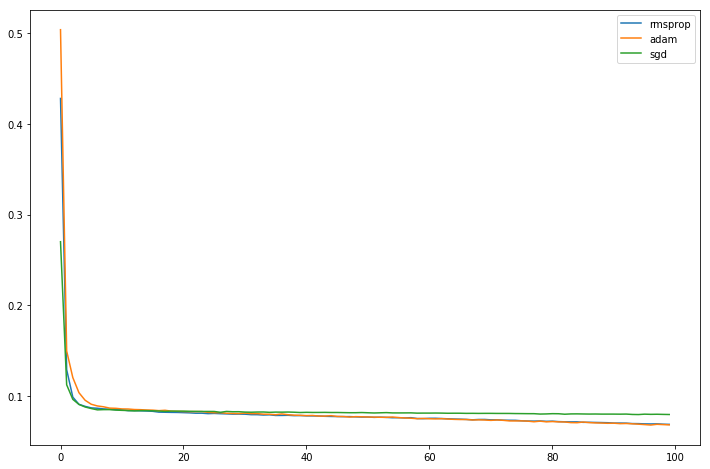

In [29]:
fig = plt.figure(figsize = (12, 8))
plt.plot(add_model1.history.history['loss'][:100])
plt.plot(add_model5.history.history['loss'][:100])
plt.plot(add_model6.history.history['loss'][:100])
plt.legend(['rmsprop', 'adam', 'sgd'])

400 epoch까지 그려서 비교해볼까요? 확실히 세 방법의 행동이 다른 게 잘 보입니다.

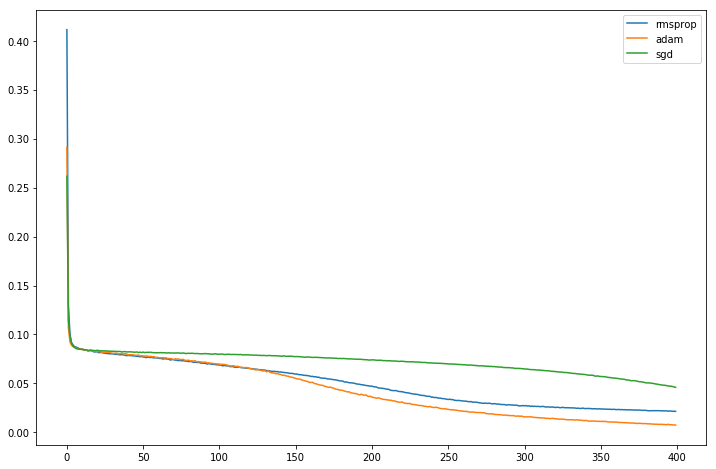

In [30]:
add_model1.load_weights('add_base_weight.hdf5')
add_model1.fit(x = x_train, y = y_train, batch_size = 10, initial_epoch=0, epochs=400, verbose = 0)

add_model5.load_weights('add_base_weight.hdf5')
add_model5.fit(x = x_train, y = y_train, batch_size = 10, initial_epoch=0, epochs=400, verbose = 0)

add_model6.load_weights('add_base_weight.hdf5')
add_model6.fit(x = x_train, y = y_train, batch_size = 10, initial_epoch=0, epochs=400, verbose = 0)

fig = plt.figure(figsize = (12, 8))
plt.plot(add_model1.history.history['loss'][:400])
plt.plot(add_model5.history.history['loss'][:400])
plt.plot(add_model6.history.history['loss'][:400])
plt.legend(['rmsprop', 'adam', 'sgd'])

loss와 accuracy는 관계가 있긴 하지만 위 그래프에서는 직접 확인하지는 못했습니다. 종종 학습 진행에 따른 accuracy도 확인해 보는 것이 필요합니다.

* **Keras**는 학습 과정에서 metric으로 'accuracy'를 지정할 수 있습니다.
* 우리 학습 자료 $y$는 1개의 실수값이며, loss를 MSE로 했기 때문에 여태까지 우리는 이 값을 계산하라고 지정할 수 없었습니다.
    * **Keras** 입장에서는 이렇게 설정된 상황에서 accuracy를 계산할 방법이 없습니다. MSE로 두 값을 비교하고 있는데 '정확도'라니...?
* 따라서 이번에는 같은 내용을 학습하면서 accuracy를 계산할 수 있도록 학습 자료 및 loss를 바꿔 볼 것입니다.    

### 데이터를 좀 조작해봅시다.

우리는 0~4 사이의 정수 1개로 나오는 $y$를 normalized해서 $[0, 1]$ 사이의 실수로 변환해서 사용했습니다. 이번에는 이것을 5개로 나뉜 구간에 대한 probability distribution으로 바꿔봅니다. 즉, 0은 원래 0이었으므로 $[1, 0, 0, 0, 0]$으로 바꾸고 0.2는 원래 1이었으므로 $[0, 1, 0, 0, 0]$로 바꾸는 식입니다.
* 이런 식으로 category 형식의 값을 한 entry만 1이고 나머지가 0인 vector로 바꾼 것을 **one-hot vector**라고 합니다.

In [31]:
y_prob = keras.utils.to_categorical(y_orig, 5)
print(y[:10])
print(y_prob[:10])

y_prob_train = y_prob[:900]
y_prob_test = y_prob

[0.4 0.8 0.8 0.2 0.2 0.4 0.6 0.2 0.  0.4]
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


이렇게 바꾼 $y_{prob}$로 학습하려면 모델 구조를 좀 바꿔야합니다.

* 출력은 5개 구간에 대한 확률분포가 되어야 하므로, 출력 layer의 cell은 5개가 되어야 합니다.
* 또한 이것을 확률분포로 바꾸기 위해 softmax layer를 추가해야 합니다.
    * softmax layer는 고정된 연산을 수행하므로 학습할 파라메터가 없는 layer입니다.
    
* 또한 loss는 이제 하나의 값이 아닌 확률분포를 비교하는 것이므로 'categorical_crossentropy'가 됩니다.

아울러 이제 모델의 출력은 확률분포 중 가장 높은 구간에 해당하는 정수로 가정할 수 있습니다. 즉

**$\hat{y}$ = np.argmax(model.predict(x), axis = 1)**

가 됩니다.

In [32]:
input_layer = Layers.Input(shape = (10, ), name = 'input_layer')
hidden_layer = Layers.Dense(units= 10, activation='tanh', name = 'hidden_layer')(input_layer)
output_layer = Layers.Dense(units = 5, activation='softmax', name = 'output_layer')(hidden_layer)

add_model_cat1 = keras.Model(input_layer, output_layer)
add_model_cat1.summary()

add_model_cat1.save_weights('add_base_weight_cat.hdf5')

add_model_cat1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

add_model_cat1.fit(x = x_train, y = y_prob_train, batch_size = 10, initial_epoch=0, epochs = 100, verbose = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 10)                0         
_________________________________________________________________
hidden_layer (Dense)         (None, 10)                110       
_________________________________________________________________
output_layer (Dense)         (None, 5)                 55        
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________


결과는 어떨까요?

In [33]:
y_hat_raw = add_model_cat1.predict(x)
y_hat = np.argmax(y_hat_raw, axis = 1)

print(y_hat_raw[:10])
print(y_hat[:10])
print(y_prob[:10])

acc = np.mean(np.equal(y_hat, y_orig))
print('정확도 = ', acc)

[[0.22491728 0.43957165 0.21109632 0.06037975 0.06403494]
 [0.26237887 0.11886135 0.11864632 0.19775203 0.3023615 ]
 [0.27353984 0.10804611 0.11450688 0.20890139 0.29500586]
 [0.30517355 0.3257539  0.1500874  0.08879191 0.13019323]
 [0.34228766 0.27016655 0.16552737 0.09624714 0.12577124]
 [0.22365224 0.4180131  0.22250374 0.06800011 0.0678308 ]
 [0.14571664 0.06397858 0.12397772 0.34116313 0.32516393]
 [0.28943154 0.33254492 0.16432996 0.07604971 0.13764384]
 [0.31282884 0.21950945 0.15498205 0.11952227 0.19315743]
 [0.20461573 0.409961   0.2554552  0.06807441 0.06189366]]
[1 4 4 1 0 1 3 1 0 1]
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
정확도 =  0.638671875


그냥 실수값으로 했을 때보다 좋아졌습니다.

이제 각 optimizer에 대해 돌려봅시다.

In [34]:
add_model_cat2 = keras.Model(input_layer, output_layer)
add_model_cat2.summary()
add_model_cat2.load_weights('add_base_weight_cat.hdf5')
add_model_cat2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
add_model_cat2.fit(x = x_train, y = y_prob_train, batch_size = 10, initial_epoch=0, epochs = 100, verbose = 0)
y_hat_raw = add_model_cat2.predict(x)
y_hat = np.argmax(y_hat_raw, axis = 1)
acc = np.mean(np.equal(y_hat, y_orig))
print('정확도 = ', acc)

add_model_cat3 = keras.Model(input_layer, output_layer)
add_model_cat3.summary()
add_model_cat3.load_weights('add_base_weight_cat.hdf5')
add_model_cat3.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
add_model_cat3.fit(x = x_train, y = y_prob_train, batch_size = 10, initial_epoch=0, epochs = 100, verbose = 0)
y_hat_raw = add_model_cat3.predict(x)
y_hat = np.argmax(y_hat_raw, axis = 1)
acc = np.mean(np.equal(y_hat, y_orig))
print('정확도 = ', acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 10)                0         
_________________________________________________________________
hidden_layer (Dense)         (None, 10)                110       
_________________________________________________________________
output_layer (Dense)         (None, 5)                 55        
Total params: 165
Trainable params: 165
Non-trainable params: 0
_________________________________________________________________
정확도 =  0.6767578125
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 10)                0         
_________________________________________________________________
hidden_layer (Dense)         (None, 10)                110       
__________________________________________________________

accuracy를 비교 도시해 보면 아래와 같습니다. loss의 상대적인 높고 낮음이 accuracy의 상대적인 낮고 높음과 정확히 일치하지 않는 것을 확인할 수 있습니다.

따라서 학습 과정에는 loss를 신경쓰되, 학습된 모델을 사용할 때는 accuracy를 신경쓰는 것이 좋습니다.

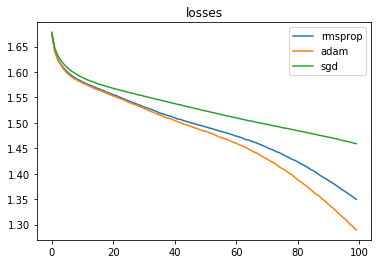

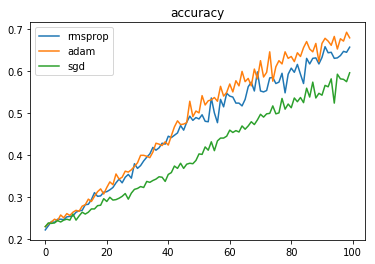

In [35]:
plt.plot(add_model_cat1.history.history['loss'][:100])
plt.plot(add_model_cat2.history.history['loss'][:100])
plt.plot(add_model_cat3.history.history['loss'][:100])
plt.legend(['rmsprop', 'adam', 'sgd'])
plt.title('losses')
plt.show()

plt.plot(add_model_cat1.history.history['acc'][:100])
plt.plot(add_model_cat2.history.history['acc'][:100])
plt.plot(add_model_cat3.history.history['acc'][:100])
plt.legend(['rmsprop', 'adam', 'sgd'])
plt.title('accuracy')
plt.show()